In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam
import matplotlib.pyplot as plt
float_formatter = "{:.6f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

$\Large \epsilon y'' + p(x,y)y' + q(x,y) = 0, \quad y(0) = \alpha, y(1) = \beta, \quad x \in [0,1]$

$\Large \epsilon y'' + 2y' + e^y = 0, \quad y(0) = y(1) = 0, \quad 0 < \epsilon << 1$

### Sol. Aalítica*: $\rightarrow y(x) = -ln(\frac{1}{2}x + \frac{1}{2}) - ln(2)e^{\frac{-2x}{\epsilon}}$

In [66]:
alpha = beta = 0.
a, b = 0., 1.

In [3]:
def p(x, y):
    return 2

def q(x, y):
    return np.exp(y)

def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    return [(rs.randn(insize, outsize) * scale,   # W
             rs.randn(outsize) * scale)           # b
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

def y(params, inputs):
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = np.tanh(outputs)
    return outputs
yp = elementwise_grad(y, 1)
ypp = elementwise_grad(yp, 1)

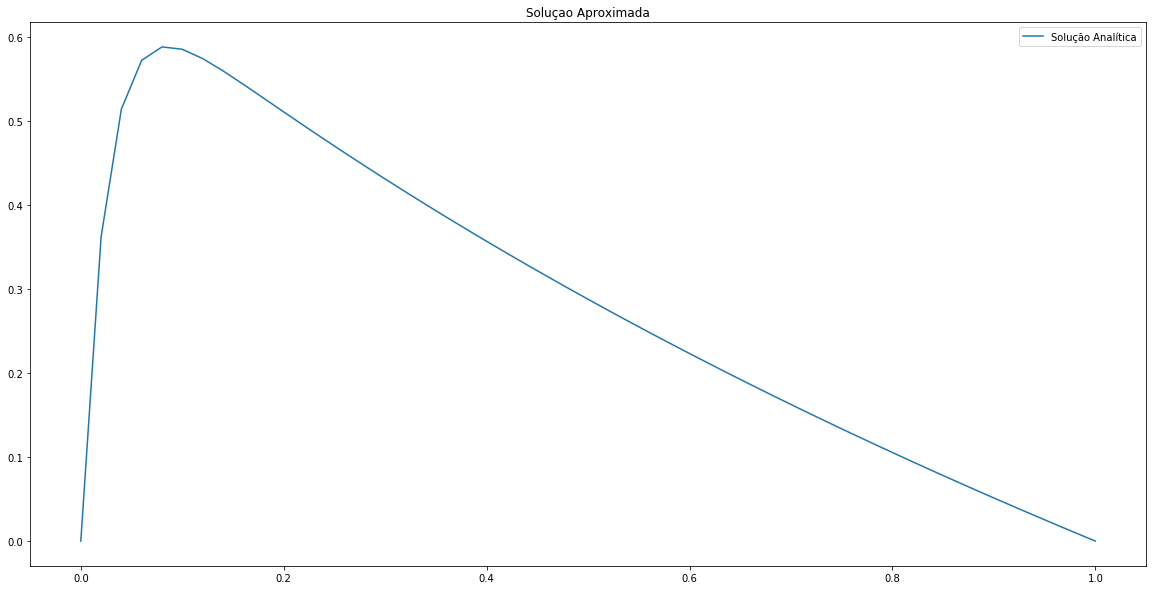

In [4]:
E = 0.05
x = np.linspace(a, b, 51).reshape((-1, 1))

def analitic(x):
#     return np.log(2/(1+x))-np.log(2)*np.exp(-2*x / E)
    return -np.log(1/2*x + 1/2) -np.log(2)*np.exp(-2*x / E)
y_analitico = analitic(x)

plt.figure(figsize=(20,10))
plt.plot(x, y_analitico, label='Solução Analítica') 
plt.legend()
plt.title('Soluçao Aproximada')
plt.show()

# Resolvendo o Segundo Layer [PVI]

In [5]:
params1 = init_random_params(0.1, layer_sizes=[1, 20, 1])

In [6]:
# Definindo os apelidos para cada PVI
u = y
up = yp

In [7]:
def objective1(params, step):
    res = p(x, u(params, x))*up(params, x) + q(x, u(params, x))
    bc0 = u(params, b) - beta # igual a zero
    return np.mean(res**2) + bc0**2

In [8]:
def callback1(params, step, g):
    if step % 1000 == 0:
        print("Iteration {0:3d} objective {1}".format(step, objective1(params, step)))

x = np.linspace(a, b, 51).reshape((-1, 1))
params1 = adam(grad(objective1), params1,
      step_size=0.001, num_iters=10000, callback=callback1)

Iteration   0 objective [[0.812511]]
Iteration 1000 objective [[0.009853]]
Iteration 2000 objective [[0.000176]]
Iteration 3000 objective [[0.000105]]
Iteration 4000 objective [[0.000092]]
Iteration 5000 objective [[0.000075]]
Iteration 6000 objective [[0.000052]]
Iteration 7000 objective [[0.000028]]
Iteration 8000 objective [[0.000010]]
Iteration 9000 objective [[0.000003]]


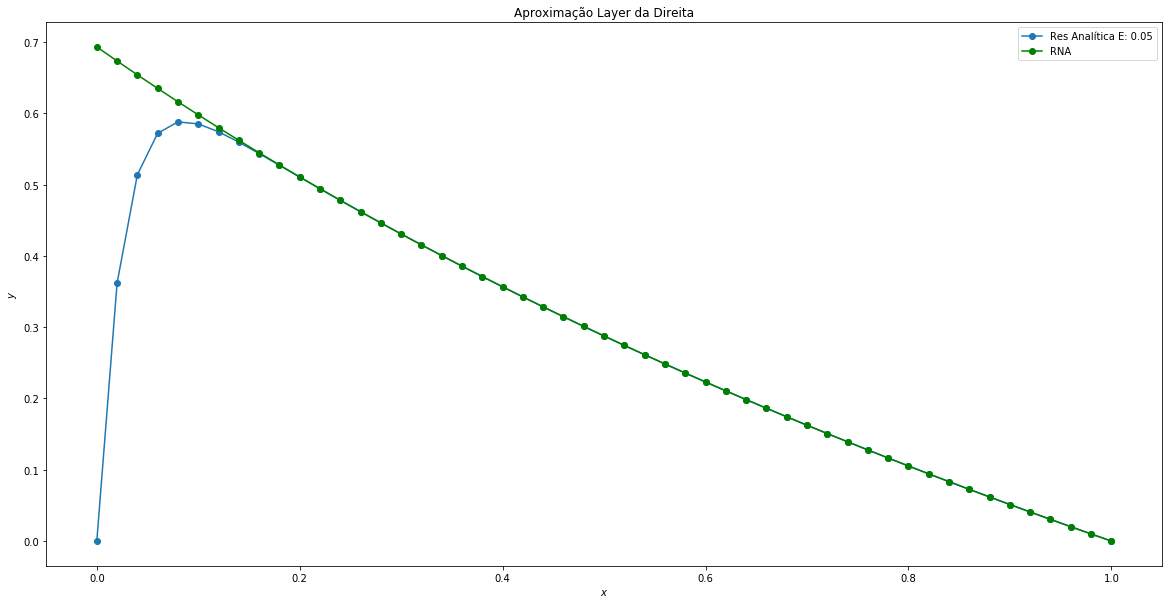

In [9]:
plt.figure(figsize=(20,10))
res = u(params1, x)
plt.plot(x, y_analitico, label='Res Analítica E: {}'.format(E), marker='o')
plt.plot(x, res, label='RNA', color='green', marker='o')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Aproximação Layer da Direita')
plt.show()

# Resolvendo o Primeiro Layer [PVC]

In [113]:
# sigma = np.min([1/2, E*np.log(51)])
sigma = 0.1
x = np.linspace(a, sigma, 51).reshape((-1, 1))

params2 = init_random_params(0.1, layer_sizes=[1, 20, 1])
# Definindo os apelidos
v = y
vp = yp
vpp = ypp

In [114]:
zero = np.broadcast_to(np.array([0.0]),(x.shape[0],1))
t = x/E
def objective2(params, step):
    
    res = vpp(params, t) + p(zero, v(params, t))*vp(params, t) + E*v(params, t)
    bc0 = v(params, a) - alpha
    bc1 = v(params, t[-1]) - u(params1, t[-1]*E)
    return np.mean(res**2) + bc0**2 + bc1**2

In [115]:
# print(objective2(params2, x))
def callback2(params, step, g):
    if step % 1000 == 0:
        print("Iteration {0:3d} objective {1}".format(step, objective2(params, step)))

params2 = adam(grad(objective2), params2,
      step_size=0.001, num_iters=10000, callback=callback2)

Iteration   0 objective [[0.302345]]
Iteration 1000 objective [[0.077456]]
Iteration 2000 objective [[0.000499]]
Iteration 3000 objective [[0.000083]]
Iteration 4000 objective [[0.000037]]
Iteration 5000 objective [[0.000022]]
Iteration 6000 objective [[0.000013]]
Iteration 7000 objective [[0.000007]]
Iteration 8000 objective [[0.000004]]
Iteration 9000 objective [[0.000002]]


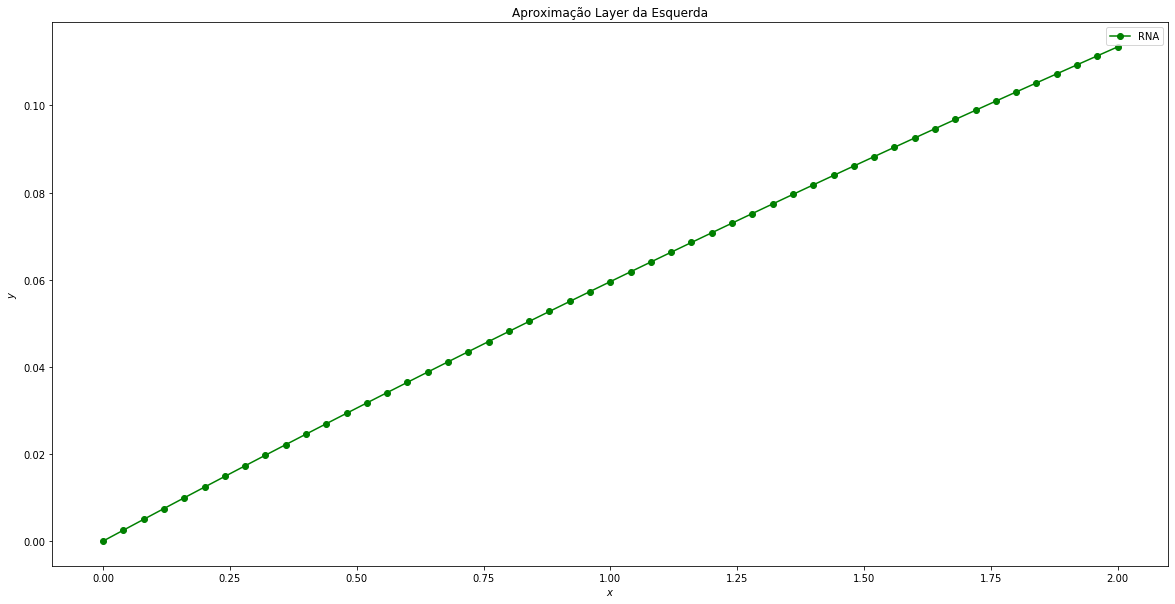

In [116]:
plt.figure(figsize=(20,10))
res = v(params2, x)

# plt.plot(x, y_analitico, label='Res Analítica E: {}'.format(E), marker='o')
plt.plot(t, res, label='RNA', color='green', marker='o')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Aproximação Layer da Esquerda')
plt.show()

# Unindo as Duas Redes para Fomar y

In [119]:
def particionar(x, tf):
    return (np.array([d[0] for d in x if d <= tf]).reshape((-1, 1)), np.array([d[0] for d in x if d > tf]).reshape((-1, 1)))

def y_aprox(x):
    t = x/E
    inner, outer = particionar(x, sigma)             
    inner = v(params2, inner/E)
    outer = u(params1, outer)
    return np.concatenate((inner, outer), axis=0)

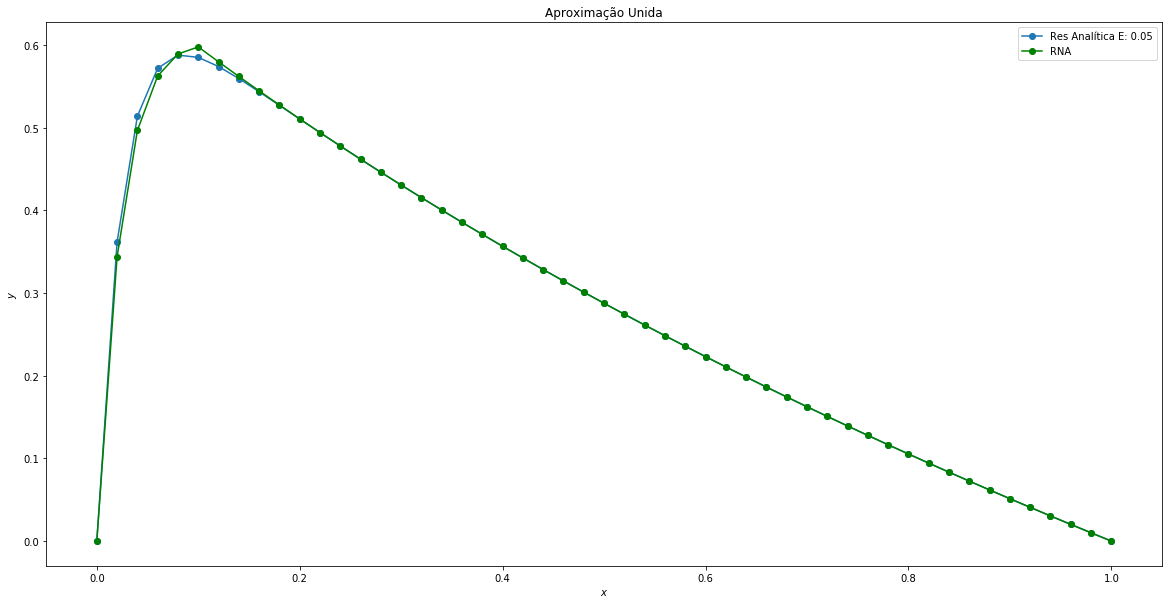

In [124]:
x = np.linspace(a, b, 51).reshape((-1, 1))
plt.figure(figsize=(20,10))
res = y_aprox(x)
plt.plot(x, analitic(x), label='Res Analítica E: {}'.format(E), marker='o')
plt.plot(x, res, label='RNA', color='green', marker='o')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Aproximação Unida')
plt.show()

# Usar os pontos Aproximados p/ Treinar uma nova Rede

In [142]:
def objective_pontos(params, step):
    return np.sum((y(params, x) - res)**2)

def objective_f(params, step):
    r = E*ypp(params, x) + p(x, y(params, x))*yp(params, x) + q(x, y(params, x))
    bc0 = y(params, a) - alpha # igual a zero
    bc1 = y(params, b) - beta # igual a zero
    return np.mean(r**2) + bc0**2 + bc1**2
paramsf = init_random_params(0.1, layer_sizes=[1, 20, 1])

In [143]:
def callback3(params, step, g):
    if step % 1000 == 0:
        print("Iteration {0:3d} objective {1}".format(step, objective_pontos(params, step)))

paramsf = adam(grad(objective_pontos), paramsf,
      step_size=0.001, num_iters=20000, callback=callback3)

Iteration   0 objective 5.250027296696348
Iteration 1000 objective 0.41367711888016406
Iteration 2000 objective 0.4127155236587407
Iteration 3000 objective 0.40965069698951145
Iteration 4000 objective 0.3775007442611621
Iteration 5000 objective 0.2602029518562092
Iteration 6000 objective 0.17184841984215268
Iteration 7000 objective 0.09961556813010335
Iteration 8000 objective 0.06418317091869757
Iteration 9000 objective 0.04561005774843836
Iteration 10000 objective 0.032193943526486406
Iteration 11000 objective 0.022142198686124426
Iteration 12000 objective 0.014840219387632896
Iteration 13000 objective 0.009756527453497168
Iteration 14000 objective 0.006384695815159389
Iteration 15000 objective 0.004237746594694688
Iteration 16000 objective 0.002871219841628976
Iteration 17000 objective 0.0019991191582336893
Iteration 18000 objective 0.0014463761235584058
Iteration 19000 objective 0.0012737651794073386


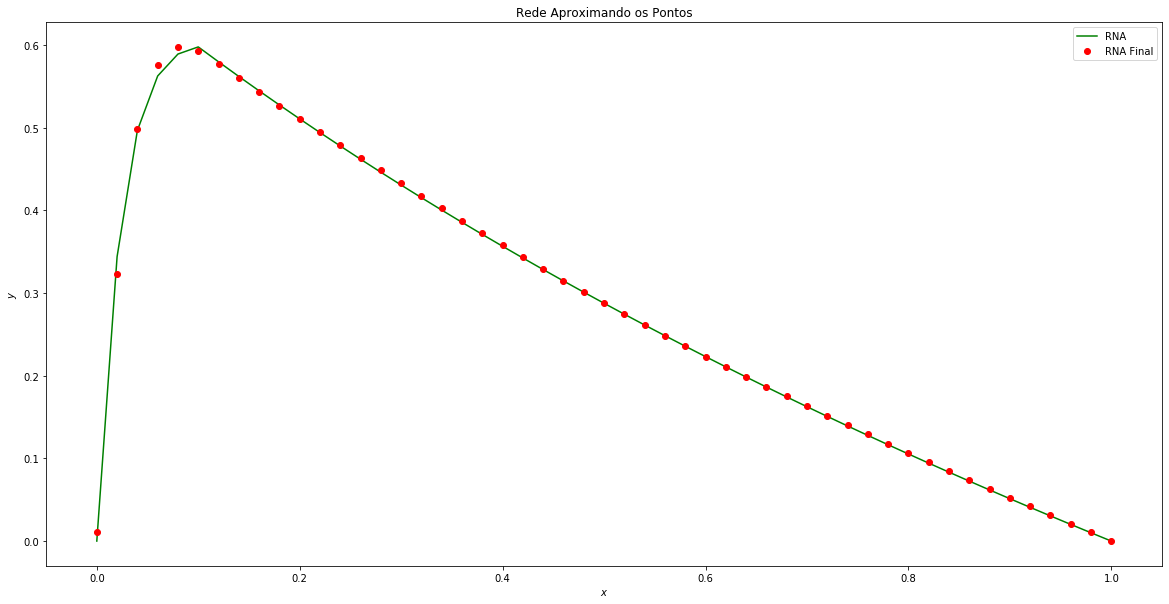

In [146]:
# x = np.linspace(a, b, 51).reshape((-1, 1))
plt.figure(figsize=(20,10))
# plt.plot(x, analitic(x), label='Res Analítica E: {}'.format(E), marker='o')
plt.plot(x, res, label='RNA', color='green', marker='')
plt.plot(x, y(paramsf, x), label='RNA Final', color='red', linestyle="", marker='o')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Rede Aproximando os Pontos')
plt.show()

In [147]:
def callback4(params, step, g):
    if step % 1000 == 0:
        print("Iteration {0:3d} objective {1}".format(step, objective_f(params, step)))

paramsf = adam(grad(objective_f), paramsf,
      step_size=0.001, num_iters=20000, callback=callback4)

Iteration   0 objective [[9.178648]]
Iteration 1000 objective [[0.128300]]
Iteration 2000 objective [[0.094118]]
Iteration 3000 objective [[0.086802]]
Iteration 4000 objective [[0.084311]]
Iteration 5000 objective [[0.083031]]
Iteration 6000 objective [[0.082006]]
Iteration 7000 objective [[0.080941]]
Iteration 8000 objective [[0.079362]]
Iteration 9000 objective [[0.076760]]
Iteration 10000 objective [[0.072397]]
Iteration 11000 objective [[0.065280]]
Iteration 12000 objective [[0.054788]]
Iteration 13000 objective [[0.041794]]
Iteration 14000 objective [[0.028590]]
Iteration 15000 objective [[0.017403]]
Iteration 16000 objective [[0.009346]]
Iteration 17000 objective [[0.004451]]
Iteration 18000 objective [[0.001948]]
Iteration 19000 objective [[0.000855]]


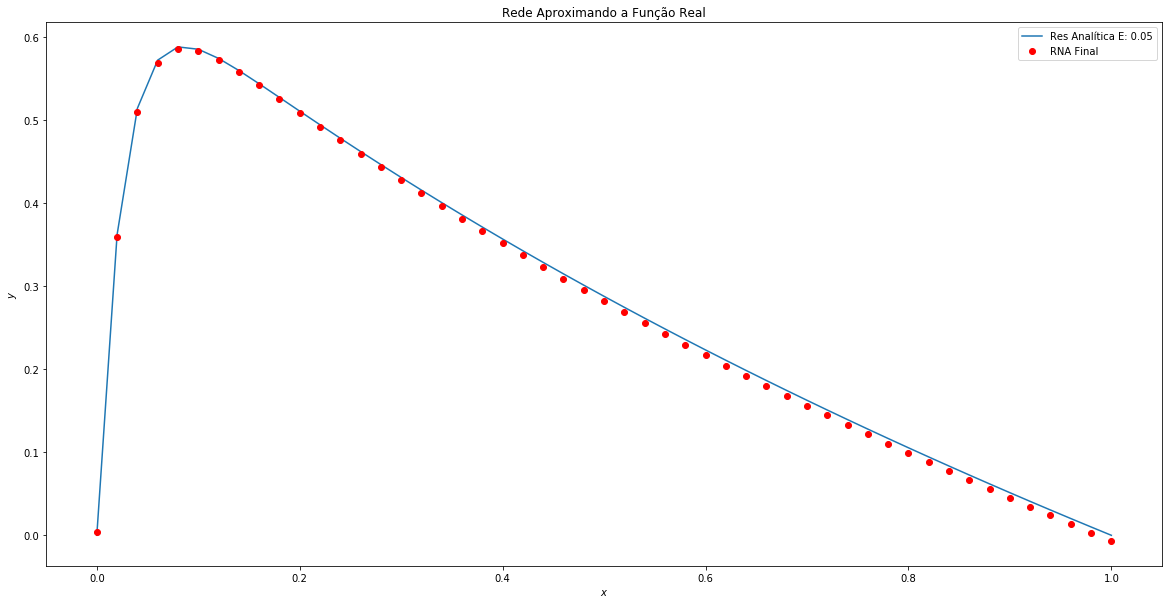

In [150]:
# x = np.linspace(a, b, 51).reshape((-1, 1))
plt.figure(figsize=(20,10))
plt.plot(x, analitic(x), label='Res Analítica E: {}'.format(E), marker='')
plt.plot(x, y(paramsf, x), label='RNA Final', color='red', linestyle="", marker='o')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Rede Aproximando a Função Real')
plt.show()